In [ ]:
import pandas as pd

# --- Charger le dataset complet ---
file = r"C:\Users\DELL\Desktop\project_fire\data\processed\dataset_final_cleanedFFFFFFFFF.csv"
df = pd.read_csv(file)
print("Dataset original :", df['fire'].value_counts(normalize=True))

# --- Séparer les classes ---
df_fire = df[df['fire'] == 1]   # feu
df_no_fire = df[df['fire'] == 0]  # pas de feu

# --- Calculer le nombre de samples nécessaires pour avoir 20% fire ---
n_fire = len(df_fire)
n_no_fire = int(n_fire * (80/20))  # pour avoir 20/80
print(f"Nombre de non-feu à garder : {n_no_fire}")

# --- Undersampling des non-feu ---
df_no_fire_sampled = df_no_fire.sample(n=n_no_fire, random_state=42)

# --- Combiner avec les données de feu ---
df_balanced = pd.concat([df_fire, df_no_fire_sampled]).sample(frac=1, random_state=42)  # shuffle

# --- Vérification du ratio ---
print("Dataset rééquilibré :", df_balanced['fire'].value_counts(normalize=True))

# --- Sauvegarde si nécessaire ---
output_file = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_soil_balanced.csv"
df_balanced.to_csv(output_file, index=False)


In [1]:
import pandas as pd

# --- Charger le dataset complet ---
file = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_soil_merged_cleaned.csv"
df = pd.read_csv(file)
print("Dataset original :", df['fire'].value_counts(normalize=True))

# --- Séparer les classes ---
df_fire = df[df['fire'] == 1]   # feu
df_no_fire = df[df['fire'] == 0]  # pas de feu

# --- Calculer le nombre de samples nécessaires pour avoir 20% fire ---
n_fire = len(df_fire)
n_no_fire = int(n_fire * (80/20))  # pour avoir 20/80
print(f"Nombre de non-feu à garder : {n_no_fire}")

# --- Undersampling des non-feu ---
df_no_fire_sampled = df_no_fire.sample(n=n_no_fire, random_state=42)

# --- Combiner avec les données de feu ---
df_balanced = pd.concat([df_fire, df_no_fire_sampled]).sample(frac=1, random_state=42)  # shuffle

# --- Vérification du ratio ---
print("Dataset rééquilibré :", df_balanced['fire'].value_counts(normalize=True))

# --- Sauvegarde si nécessaire ---
output_file = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_soil_balanced.csv"
df_balanced.to_csv(output_file, index=False)


C:\Users\DELL\AppData\Local\Temp\ipykernel_13260\2035369487.py:5: DtypeWarning: Columns (0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Dataset original : fire
0       9.839467e-01
1       8.984062e-03
0       5.241062e-03
1       1.827706e-03
fire    4.314697e-07
Name: proportion, dtype: float64
Nombre de non-feu à garder : 83288
Dataset rééquilibré : fire
0    0.8
1    0.2
Name: proportion, dtype: float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_13260\3867980346.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, usecols=['fire'], chunksize=chunk_size):


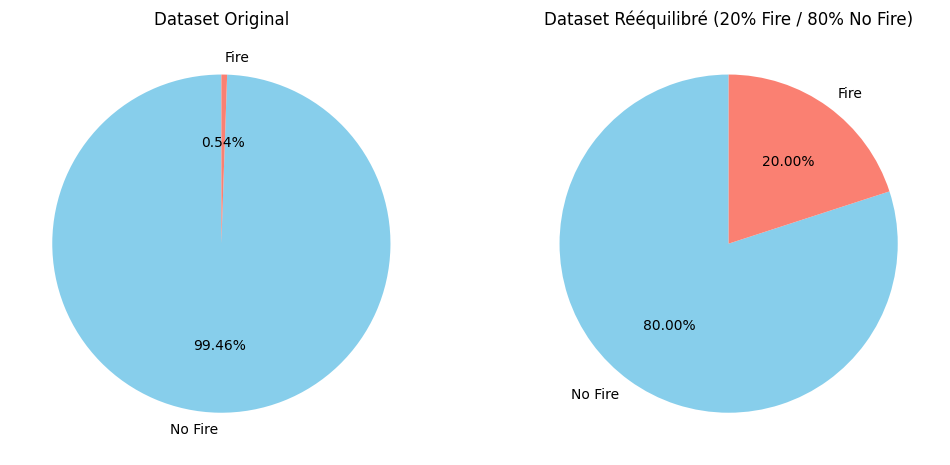

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Fichiers ---
file_original = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_soil_merged_cleaned.csv"
file_balanced = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_soil_balanced.csv"

# --- Fonction pour compter les classes en chunks ---
def count_fire_classes(file_path, chunk_size=500_000):
    count_fire = 0
    count_no_fire = 0
    for chunk in pd.read_csv(file_path, usecols=['fire'], chunksize=chunk_size):
        count_fire += (chunk['fire'] == 1).sum()
        count_no_fire += (chunk['fire'] == 0).sum()
    return pd.Series([count_no_fire, count_fire], index=['No Fire', 'Fire'])

# --- Comptage ---
counts_original = count_fire_classes(file_original)
counts_balanced = count_fire_classes(file_balanced)

# --- Visualisation avec pie chart ---
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Original
axes[0].pie(counts_original, labels=counts_original.index, autopct='%1.2f%%', startangle=90, colors=['skyblue','salmon'])
axes[0].set_title("Dataset Original")

# Rééquilibré
axes[1].pie(counts_balanced, labels=counts_balanced.index, autopct='%1.2f%%', startangle=90, colors=['skyblue','salmon'])
axes[1].set_title("Dataset Rééquilibré (20% Fire / 80% No Fire)")

plt.show()


In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os

# --- Fichiers ---
file_input = r"C:\Users\DELL\Desktop\project_fire\data\processed\fire_soil_balanced.csv"
file_output = r"D:\project_fire\df_balanced_normalized_encoded_chunks.csv.gz"

os.makedirs(os.path.dirname(file_output), exist_ok=True)

chunk_size = 200_000  # nombre de lignes par chunk
scaler = MinMaxScaler()
first_chunk = True

for chunk in pd.read_csv(file_input, chunksize=chunk_size):
    # Supprimer 'geometry' si elle existe
    if 'geometry' in chunk.columns:
        chunk = chunk.drop(columns=['geometry'])
    
    # Séparer X et y
    X = chunk.drop(columns=['fire'])
    y = chunk['fire']
    
    # Encodage des colonnes catégorielles
    cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    # Normalisation MinMax des colonnes numériques
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if num_cols:
        X[num_cols] = scaler.fit_transform(X[num_cols])
    
    # Reconstituer le chunk final
    df_chunk = pd.concat([X, y], axis=1)
    
    # Écrire le chunk dans le CSV final
    if first_chunk:
        df_chunk.to_csv(file_output, index=False, mode='w')
        first_chunk = False
    else:
        df_chunk.to_csv(file_output, index=False, mode='a', header=False)

print("Dataset normalisé et encodé par chunks sauvegardé :", file_output)


Dataset normalisé et encodé par chunks sauvegardé : D:\project_fire\df_balanced_normalized_encoded_chunks.csv.gz


In [23]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np

# --- Fichiers ---
file_input = r"C:\Users\DELL\Desktop\project_fire\data\processed\final_datasets\df_balanced_normalized_encoded.csv"
output_dir = r"D:\project_fire\final_datasets"  # disque avec plus d'espace
os.makedirs(output_dir, exist_ok=True)

chunk_size = 200_000
train_ratio = 0.7  # 80% training, 20% test
first_train_chunk = True
first_test_chunk = True

# --- Lecture par chunks ---
for chunk in pd.read_csv(file_input, chunksize=chunk_size):
    # Supprimer 'geometry' si elle existe
    if 'geometry' in chunk.columns:
        chunk = chunk.drop(columns=['geometry'])
    
    # Séparer X et y
    X = chunk.drop(columns=['fire'])
    y = chunk['fire']
    
    # Encodage des colonnes catégorielles
    cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    # Normalisation MinMax des colonnes numériques
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if num_cols:
        scaler = MinMaxScaler()
        X[num_cols] = scaler.fit_transform(X[num_cols])
    
    # Reconstituer le chunk
    df_chunk = pd.concat([X, y], axis=1)
    
    # --- Split aléatoire en training/test ---
    mask = np.random.rand(len(df_chunk)) < train_ratio
    df_train_chunk = df_chunk[mask]
    df_test_chunk = df_chunk[~mask]
    
    # --- Écriture directe sur disque avec compression gzip ---
    train_file = os.path.join(output_dir, "train.csv.gz")
    test_file = os.path.join(output_dir, "test.csv.gz")
    
    if first_train_chunk:
        df_train_chunk.to_csv(train_file, index=False, mode='w', compression='gzip')
        first_train_chunk = False
    else:
        df_train_chunk.to_csv(train_file, index=False, mode='a', header=False, compression='gzip')
    
    if first_test_chunk:
        df_test_chunk.to_csv(test_file, index=False, mode='w', compression='gzip')
        first_test_chunk = False
    else:
        df_test_chunk.to_csv(test_file, index=False, mode='a', header=False, compression='gzip')

print("Datasets training et test sauvegardés par chunks avec gzip :", train_file, test_file)


Datasets training et test sauvegardés par chunks avec gzip : D:\project_fire\final_datasets\train.csv.gz D:\project_fire\final_datasets\test.csv.gz


In [24]:
import pandas as pd

# Charger training et test (gzip)
train = pd.read_csv(r"D:\project_fire\final_datasets\train.csv.gz", compression='gzip')
test = pd.read_csv(r"D:\project_fire\final_datasets\test.csv.gz", compression='gzip')

# Séparer features et target
X_train = train.drop(columns=['fire'])
y_train = train['fire']
X_test = test.drop(columns=['fire'])
y_test = test['fire']

print("Training:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)


Training: (20296, 42) (20296,)
Test: (8816, 42) (8816,)


In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Paramètres à tester
k_values = [3, 5, 7, 9, 11]          # nombre de voisins
weights_options = ['uniform', 'distance']  # poids
metrics_options = ['euclidean', 'manhattan', 'minkowski']  # métriques de distance

results = []

# Boucle sur toutes les combinaisons
for k in k_values:
    for w in weights_options:
        for m in metrics_options:
            knn = KNeighborsClassifier(n_neighbors=k, weights=w, metric=m, n_jobs=-1)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            
            acc = accuracy_score(y_test, y_pred)
            results.append({
                'k': k,
                'weights': w,
                'metric': m,
                'accuracy': acc
            })
            print(f"k={k}, weights={w}, metric={m}, accuracy={acc:.4f}")


k=3, weights=uniform, metric=euclidean, accuracy=0.9108
k=3, weights=uniform, metric=manhattan, accuracy=0.9179
k=3, weights=uniform, metric=minkowski, accuracy=0.9108
k=3, weights=distance, metric=euclidean, accuracy=0.9175
k=3, weights=distance, metric=manhattan, accuracy=0.9249
k=3, weights=distance, metric=minkowski, accuracy=0.9175
k=5, weights=uniform, metric=euclidean, accuracy=0.9099
k=5, weights=uniform, metric=manhattan, accuracy=0.9147
k=5, weights=uniform, metric=minkowski, accuracy=0.9099
k=5, weights=distance, metric=euclidean, accuracy=0.9175
k=5, weights=distance, metric=manhattan, accuracy=0.9254
k=5, weights=distance, metric=minkowski, accuracy=0.9175
k=7, weights=uniform, metric=euclidean, accuracy=0.9060
k=7, weights=uniform, metric=manhattan, accuracy=0.9139
k=7, weights=uniform, metric=minkowski, accuracy=0.9060
k=7, weights=distance, metric=euclidean, accuracy=0.9194
k=7, weights=distance, metric=manhattan, accuracy=0.9266
k=7, weights=distance, metric=minkowski,

In [27]:
results_df = pd.DataFrame(results)
# Trier par meilleure accuracy
results_df = results_df.sort_values(by='accuracy', ascending=False)
print("Top 5 k-NN configurations :")
print(results_df.head())


Top 5 k-NN configurations :
     k   weights     metric  accuracy
22   9  distance  manhattan  0.928539
28  11  distance  manhattan  0.928085
16   7  distance  manhattan  0.926611
10   5  distance  manhattan  0.925363
4    3  distance  manhattan  0.924909


In [28]:
# Meilleur modèle
best = results_df.iloc[0]
best_knn = KNeighborsClassifier(
    n_neighbors=best['k'],
    weights=best['weights'],
    metric=best['metric'],
    n_jobs=-1
)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Classification report (best k-NN):")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Classification report (best k-NN):
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      7086
           1       0.79      0.86      0.83      1730

    accuracy                           0.93      8816
   macro avg       0.88      0.90      0.89      8816
weighted avg       0.93      0.93      0.93      8816

Confusion matrix:
[[6695  391]
 [ 239 1491]]


In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Sur training set ---
y_train_pred = best_knn.predict(X_train)
print("Training set:")
print(classification_report(y_train, y_train_pred))
print("Accuracy:", accuracy_score(y_train, y_train_pred))

# --- Sur test set ---
y_test_pred = best_knn.predict(X_test)
print("Test set:")
print(classification_report(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))


Training set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16251
           1       1.00      1.00      1.00      4045

    accuracy                           1.00     20296
   macro avg       1.00      1.00      1.00     20296
weighted avg       1.00      1.00      1.00     20296

Accuracy: 1.0
Test set:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      7086
           1       0.79      0.86      0.83      1730

    accuracy                           0.93      8816
   macro avg       0.88      0.90      0.89      8816
weighted avg       0.93      0.93      0.93      8816

Accuracy: 0.9285390199637024


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import os

# --- Fichiers ---
file_input = r"C:\Users\DELL\Desktop\project_fire\data\processed\final_datasets\df_balanced_normalized_encoded.csv"
output_dir = r"D:\project_fire\final_datasets"
os.makedirs(output_dir, exist_ok=True)

chunk_size = 200_000
train_ratio = 0.7
first_train_chunk = True
first_test_chunk = True

# --- Lecture par chunks pour split training/test ---
for chunk in pd.read_csv(file_input, chunksize=chunk_size):
    # Supprimer geometry si existante
    if 'geometry' in chunk.columns:
        chunk = chunk.drop(columns=['geometry'])
    
    # Séparer X et y
    X = chunk.drop(columns=['fire'])
    y = chunk['fire']
    
    # Encodage des colonnes catégorielles
    cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    # Normalisation MinMax
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if num_cols:
        scaler = MinMaxScaler()
        X[num_cols] = scaler.fit_transform(X[num_cols])
    
    # Reconstituer chunk
    df_chunk = pd.concat([X, y], axis=1)
    
    # --- Split aléatoire train/test ---
    mask = np.random.rand(len(df_chunk)) < train_ratio
    df_train_chunk = df_chunk[mask]
    df_test_chunk = df_chunk[~mask]
    
    # --- Sauvegarde gzip ---
    train_file = os.path.join(output_dir, "train.csv.gz")
    test_file = os.path.join(output_dir, "test.csv.gz")
    
    if first_train_chunk:
        df_train_chunk.to_csv(train_file, index=False, mode='w', compression='gzip')
        first_train_chunk = False
    else:
        df_train_chunk.to_csv(train_file, index=False, mode='a', header=False, compression='gzip')
    
    if first_test_chunk:
        df_test_chunk.to_csv(test_file, index=False, mode='w', compression='gzip')
        first_test_chunk = False
    else:
        df_test_chunk.to_csv(test_file, index=False, mode='a', header=False, compression='gzip')

print("Training et test sets sauvegardés par chunks avec gzip.")

# --- Charger le dataset complet pour entraînement du meilleur k-NN ---
train = pd.read_csv(train_file, compression='gzip')
test = pd.read_csv(test_file, compression='gzip')

X_train = train.drop(columns=['fire'])
y_train = train['fire']
X_test = test.drop(columns=['fire'])
y_test = test['fire']

# --- Meilleur k-NN ---
best_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan', n_jobs=-1)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

# --- Évaluation ---
print("Classification report (test set) :")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Training et test sets sauvegardés par chunks avec gzip.
Classification report (test set) :
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      6981
           1       0.80      0.85      0.82      1778

    accuracy                           0.93      8759
   macro avg       0.88      0.90      0.89      8759
weighted avg       0.93      0.93      0.93      8759

Accuracy: 0.9265897933554059


In [31]:
from sklearn.metrics import classification_report, accuracy_score

# Prédiction sur le training set
y_train_pred = best_knn.predict(X_train)

print("Classification report (training set) :")
print(classification_report(y_train, y_train_pred))

print("Accuracy (training set):", accuracy_score(y_train, y_train_pred))


Classification report (training set) :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16306
           1       1.00      1.00      1.00      4040

    accuracy                           1.00     20346
   macro avg       1.00      1.00      1.00     20346
weighted avg       1.00      1.00      1.00     20346

Accuracy (training set): 1.0


In [34]:
import pandas as pd

# Fichiers compressés
train_file = r"D:\project_fire\final_datasets\train.csv.gz"
test_file = r"D:\project_fire\final_datasets\test.csv.gz"

chunk_size = 200_000  # ajuster selon la RAM

# --- Fonction pour calculer la distribution de la target par chunks ---
def distribution_by_chunks(file_path, chunk_size=200_000, target='fire'):
    counts = {}
    total_rows = 0

    for chunk in pd.read_csv(file_path, chunksize=chunk_size, compression='gzip'):
        value_counts = chunk[target].value_counts()
        for k, v in value_counts.items():
            counts[k] = counts.get(k, 0) + v
        total_rows += len(chunk)

    # Convertir en proportions
    proportions = {k: v / total_rows for k, v in counts.items()}
    return proportions

# --- Training set ---
train_dist = distribution_by_chunks(train_file, chunk_size)
print("Training set distribution:")
print(train_dist)

# --- Test set ---
test_dist = distribution_by_chunks(test_file, chunk_size)
print("\nTest set distribution:")
print(test_dist)


Training set distribution:
{0: 0.801435171532488, 1: 0.19856482846751203}

Test set distribution:
{0: 0.8020762035135752, 1: 0.19792379648642483}


In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTETomek
import os
import numpy as np

# --- Fichiers ---
file_input =r"C:\Users\DELL\Desktop\project_fire\data\processed\final_datasets\df_balanced_normalized_encoded.csv"
output_dir = r"D:\project_fire\final_datasets_combi"
os.makedirs(output_dir, exist_ok=True)

chunk_size = 200_000
train_ratio = 0.7  # 70% training, 30% test
first_train_chunk = True
first_test_chunk = True

# --- Lecture par chunks ---
for chunk in pd.read_csv(file_input, chunksize=chunk_size):
    # Supprimer 'geometry' si elle existe
    if 'geometry' in chunk.columns:
        chunk = chunk.drop(columns=['geometry'])
    
    # Séparer X et y
    X = chunk.drop(columns=['fire'])
    y = chunk['fire']
    
    # Encodage des colonnes catégorielles
    cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    # Normalisation MinMax des colonnes numériques
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if num_cols:
        scaler = MinMaxScaler()
        X[num_cols] = scaler.fit_transform(X[num_cols])
    
    # --- Combinaison SMOTE + Undersampling ---
    smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42)  # 50% minorité / 50% majorité
    X_res, y_res = smote_tomek.fit_resample(X, y)
    
    # Reconstituer le chunk transformé
    df_chunk = pd.concat([X_res, y_res], axis=1)
    
    # --- Split aléatoire en training/test ---
    mask = np.random.rand(len(df_chunk)) < train_ratio
    df_train_chunk = df_chunk[mask]
    df_test_chunk = df_chunk[~mask]
    
    # --- Écriture directe sur disque avec compression gzip ---
    train_file = os.path.join(output_dir, "train_combi.csv.gz")
    test_file = os.path.join(output_dir, "test_combi.csv.gz")
    
    if first_train_chunk:
        df_train_chunk.to_csv(train_file, index=False, mode='w', compression='gzip')
        first_train_chunk = False
    else:
        df_train_chunk.to_csv(train_file, index=False, mode='a', header=False, compression='gzip')
    
    if first_test_chunk:
        df_test_chunk.to_csv(test_file, index=False, mode='w', compression='gzip')
        first_test_chunk = False
    else:
        df_test_chunk.to_csv(test_file, index=False, mode='a', header=False, compression='gzip')

print("Datasets training et test (SMOTE + Undersampling) sauvegardés par chunks avec gzip :")
print(train_file)
print(test_file)


Datasets training et test (SMOTE + Undersampling) sauvegardés par chunks avec gzip :
D:\project_fire\final_datasets_combi\train_combi.csv.gz
D:\project_fire\final_datasets_combi\test_combi.csv.gz


In [8]:
import pandas as pd

def check_distribution(file_path, chunk_size=200_000):
    counts = {}
    total_rows = 0
    for chunk in pd.read_csv(file_path, chunksize=chunk_size, compression='gzip'):
        vc = chunk['fire'].value_counts()
        for k, v in vc.items():
            counts[k] = counts.get(k, 0) + v
        total_rows += len(chunk)
    proportions = {k: v/total_rows for k, v in counts.items()}
    return proportions

train_dist = check_distribution(r"D:\project_fire\final_datasets_combi\train_combi.csv.gz")
test_dist = check_distribution(r"D:\project_fire\final_datasets_combi\test_combi.csv.gz")

print("Training set distribution :", train_dist)
print("Test set distribution :", test_dist)


Training set distribution : {0: 0.668125182314456, 1: 0.331874817685544}
Test set distribution : {0: 0.6735106998264893, 1: 0.3264893001735107}


In [9]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# --- Fichiers ---
train_file = r"D:\project_fire\final_datasets_combi\train_combi.csv.gz"
test_file = r"D:\project_fire\final_datasets_combi\test_combi.csv.gz"

# --- Paramètres k-NN ---
k = 5
weights = 'distance'  # 'uniform' ou 'distance'
metric = 'manhattan'  # 'euclidean', 'manhattan', etc.

# --- Lire tout le training set par chunks et concaténer (attention mémoire) ---
chunk_size = 200_000
train_chunks = []
for chunk in pd.read_csv(train_file, chunksize=chunk_size, compression='gzip'):
    train_chunks.append(chunk)
train_df = pd.concat(train_chunks, ignore_index=True)

X_train = train_df.drop(columns=['fire'])
y_train = train_df['fire']

# --- Normalisation si nécessaire ---
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# --- Entraîner k-NN ---
knn = KNeighborsClassifier(n_neighbors=k, weights=weights, metric=metric, n_jobs=-1)
knn.fit(X_train, y_train)

# --- Lire le test set par chunks et concaténer ---
test_chunks = []
for chunk in pd.read_csv(test_file, chunksize=chunk_size, compression='gzip'):
    test_chunks.append(chunk)
test_df = pd.concat(test_chunks, ignore_index=True)

X_test = test_df.drop(columns=['fire'])
y_test = test_df['fire']

# Normalisation avec le même scaler
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# --- Prédictions ---
y_pred = knn.predict(X_test)

# --- Évaluation ---
print("Classification report (test set) :")
print(classification_report(y_test, y_pred))

print("Confusion matrix (test set) :")
print(confusion_matrix(y_test, y_pred))

accuracy = (y_pred == y_test).mean()
print("Accuracy (test set) :", accuracy)


Classification report (test set) :
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      6987
           1       0.86      0.97      0.91      3387

    accuracy                           0.94     10374
   macro avg       0.92      0.95      0.93     10374
weighted avg       0.94      0.94      0.94     10374

Confusion matrix (test set) :
[[6450  537]
 [ 112 3275]]
Accuracy (test set) : 0.9374397532292269


In [10]:
from sklearn.metrics import accuracy_score

# Supposons que ton modèle est déjà entraîné : knn
# Et que X_train et y_train sont tes données de training

# Prédire sur le training set
y_train_pred = knn.predict(X_train)

# Calculer l'accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)

print("Accuracy (training set) :", train_accuracy)


Accuracy (training set) : 1.0


In [11]:
print(train_df['fire'].value_counts(normalize=True))
print(test_df['fire'].value_counts(normalize=True))


fire
0    0.668125
1    0.331875
Name: proportion, dtype: float64
fire
0    0.673511
1    0.326489
Name: proportion, dtype: float64


In [12]:
import pandas as pd
import numpy as np
from collections import Counter

# =============================
# K-Nearest Neighbors from scratch
# =============================
class KNNClassifier:
    def __init__(self, k=5):
        """
        k : nombre de voisins à considérer
        """
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Stocke simplement les données d'entraînement.
        Pas d'entraînement réel nécessaire pour k-NN.
        """
        self.X_train = X
        self.y_train = y

    def _euclidean_distance(self, x1, x2):
        """
        Calcule la distance Euclidienne entre deux points.
        """
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def _predict_one(self, x):
        """
        Prédit la classe pour un seul exemple x.
        """
        # Calculer la distance de x à tous les points d'entraînement
        distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        
        # Récupérer les indices des k plus proches voisins
        k_indices = np.argsort(distances)[:self.k]
        
        # Récupérer les labels de ces k voisins
        k_labels = [self.y_train[i] for i in k_indices]
        
        # Retourner la classe majoritaire
        return Counter(k_labels).most_common(1)[0][0]

    def predict(self, X):
        """
        Prédit les classes pour toutes les observations de X.
        """
        return np.array([self._predict_one(x) for x in X])

    def score(self, X, y):
        """
        Calcul de l'accuracy
        """
        return np.mean(self.predict(X) == y)


# =============================
# Chargement des datasets par chunks
# =============================

train_file = r"D:\project_fire\final_datasets_combi\train_combi.csv.gz"
test_file  = r"D:\project_fire\final_datasets_combi\test_combi.csv.gz"
chunk_size = 200_000

# --- Charger le training set par chunks ---
X_train_list, y_train_list = [], []

for chunk in pd.read_csv(train_file, chunksize=chunk_size, compression='gzip'):
    X_chunk = chunk.drop(columns=['fire']).values
    y_chunk = chunk['fire'].values
    X_train_list.append(X_chunk)
    y_train_list.append(y_chunk)

X_train = np.vstack(X_train_list)  # concaténation de tous les chunks
y_train = np.hstack(y_train_list)
print("Training set chargé :", X_train.shape, y_train.shape)

# --- Charger le test set par chunks ---
X_test_list, y_test_list = [], []

for chunk in pd.read_csv(test_file, chunksize=chunk_size, compression='gzip'):
    X_test_list.append(chunk.drop(columns=['fire']).values)
    y_test_list.append(chunk['fire'].values)

X_test = np.vstack(X_test_list)
y_test = np.hstack(y_test_list)
print("Test set chargé :", X_test.shape, y_test.shape)

# =============================
# Entraînement et prédiction
# =============================
k = 5  # nombre de voisins
knn = KNNClassifier(k=k)
knn.fit(X_train, y_train)  # stocke le training set

# --- Prédire sur le test set ---
y_pred = knn.predict(X_test)

# --- Évaluation ---
accuracy = np.mean(y_pred == y_test)
print("Accuracy (test set) :", accuracy)

# --- Confusion matrix ---
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print("Confusion matrix (test set) :\n", conf_matrix)


Training set chargé : (23997, 42) (23997,)
Test set chargé : (10374, 42) (10374,)
Accuracy (test set) : 0.9179679969153653
Confusion matrix (test set) :
 Predicted     0     1
Actual               
0          6364   623
1           228  3159


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import os

# --- Fichiers ---
file_input = r"C:\Users\DELL\Desktop\project_fire\data\processed\final_datasets\df_balanced_normalized_encoded.csv"
output_dir = r"D:\project_fire\final_datasets"
os.makedirs(output_dir, exist_ok=True)

chunk_size = 200_000
train_ratio = 0.7
first_train_chunk = True
first_test_chunk = True

# -------------------------
# 1) Split TRAIN / TEST en chunks (sans normalisation ici!)
# -------------------------
for chunk in pd.read_csv(file_input, chunksize=chunk_size):

    # Supprimer colonne geometry si existe
    if "geometry" in chunk.columns:
        chunk = chunk.drop(columns=["geometry"])

    # Séparer X et y
    y = chunk["fire"]
    X = chunk.drop(columns=["fire"])

    # Split aléatoire
    mask = np.random.rand(len(chunk)) < train_ratio
    df_train_chunk = chunk[mask]
    df_test_chunk = chunk[~mask]

    # Sauvegarde gzip
    train_file = os.path.join(output_dir, "train_raw.csv.gz")
    test_file = os.path.join(output_dir, "test_raw.csv.gz")

    if first_train_chunk:
        df_train_chunk.to_csv(train_file, index=False, compression="gzip", mode="w")
        first_train_chunk = False
    else:
        df_train_chunk.to_csv(train_file, index=False, compression="gzip", mode="a", header=False)

    if first_test_chunk:
        df_test_chunk.to_csv(test_file, index=False, compression="gzip", mode="w")
        first_test_chunk = False
    else:
        df_test_chunk.to_csv(test_file, index=False, compression="gzip", mode="a", header=False)

print("✔ TRAIN / TEST générés sans fuite de données.")

# -------------------------
# 2) Charger les données complètes après split
# -------------------------
train = pd.read_csv(train_file, compression="gzip")
test = pd.read_csv(test_file, compression="gzip")

# -------------------------
# 3) Encodage identique train/test
# -------------------------
y_train = train["fire"]
X_train = train.drop(columns=["fire"])

y_test = test["fire"]
X_test = test.drop(columns=["fire"])

# Encodage catégoriel sur train
cat_cols = X_train.select_dtypes(exclude=["int64", "float64"]).columns.tolist()
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)

# Appliquer exactement les mêmes colonnes à X_test
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# -------------------------
# 4) Normalisation CORRECTE : fit sur TRAIN puis transform test
# -------------------------
scaler = MinMaxScaler()
X_train.loc[:, :] = scaler.fit_transform(X_train)
X_test.loc[:, :] = scaler.transform(X_test)

# -------------------------
# 5) Entraînement KNN optimisé
# -------------------------
best_knn = KNeighborsClassifier(
    n_neighbors=11,
    weights="distance",
    metric="manhattan",
    n_jobs=-1
)

best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

# -------------------------
# 6) Évaluation
# -------------------------
print("\n=== Classification Report (TEST) ===")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


✔ TRAIN / TEST générés sans fuite de données.


C:\Users\DELL\AppData\Local\Temp\ipykernel_7748\4266596771.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1. 1. 1. ... 0. 1. 1.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X_train.loc[:, :] = scaler.fit_transform(X_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_7748\4266596771.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X_train.loc[:, :] = scaler.fit_transform(X_train)
C:\Users\DELL\AppData\Local\Temp\ipykernel_7748\4266596771.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X_train.l


=== Classification Report (TEST) ===
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      6988
           1       0.77      0.86      0.81      1705

    accuracy                           0.92      8693
   macro avg       0.87      0.90      0.88      8693
weighted avg       0.93      0.92      0.92      8693

Accuracy: 0.9226964224088346


In [4]:
# --- Accuracy sur TRAIN ---
y_train_pred = best_knn.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 1.0
